## COVID-19 NOTEBOOK

Análise aos dados de Covid-19 de Portugal com base nos relatórios publicados pela [DGS](https://covid19.min-saude.pt/relatorio-de-situacao/)

### Secções
1. [Evolução dos Casos](#evolucao_casos)
2. [Taxas de crescimento](#taxas_crescimento)
3. [Número de testes](#numero_testes)
4. [Comparação com outros países](#comparacao_outros_paises)


In [110]:
# fonte: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')



In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline


In [112]:
dados_pt = pd.read_csv('Covid-19 - Portugal.csv')

# olhar para periodo acima deste numero de casos
n_casos_analise = 200

pt_casos = dados_pt.loc[dados_pt['ConfirmedCases'] >= n_casos_analise, :].copy()

pt_casos['ndia'] = np.arange(len(pt_casos['ConfirmedCases']))

pt_casos['NewCases'] = pt_casos['ConfirmedCases'].diff()
pt_casos['NewCasesPerc'] = (pt_casos['NewCases'] / pt_casos['ConfirmedCases'])*100
pt_casos['HospitalizedPerc'] = (pt_casos['Hospitalized'] / pt_casos['ConfirmedCases'])*100
pt_casos['UCIPerc'] = (pt_casos['UCI'] / pt_casos['ConfirmedCases'])*100
pt_casos['DeathsPerc'] = (pt_casos['Deaths'] / pt_casos['ConfirmedCases'])*100
pt_casos['RecoveredPerc'] = (pt_casos['Recovered'] / pt_casos['ConfirmedCases'])*100

pt_casos['NewTests'] = pt_casos['TotalTests'].diff()

pt_casos['LogGrowthCases'] = np.log(pt_casos['ConfirmedCases'])
pt_casos['LogGrowthHospitalized'] = np.log(pt_casos['Hospitalized'])
pt_casos['LogGrowthUCI'] = np.log(pt_casos['UCI'])
pt_casos['LogGrowthRecovered'] = np.log(pt_casos['Recovered'])

# warning divide by 0
pt_casos['LogGrowthDeaths'] = np.log(pt_casos.Deaths[pt_casos['Deaths'] > 0])

# Dates
pt_casos['Date'] = pd.to_datetime(pt_casos['Date'], format=r"%d/%m/%Y")


## Evolução dos casos <a name="evolucao_casos"></a>

Evolução dos casos de cada quantidade a partir dos 200 casos confirmados. 

### Casos confirmados, Óbitos e Recuperados

Nº de casos são valores acumulados

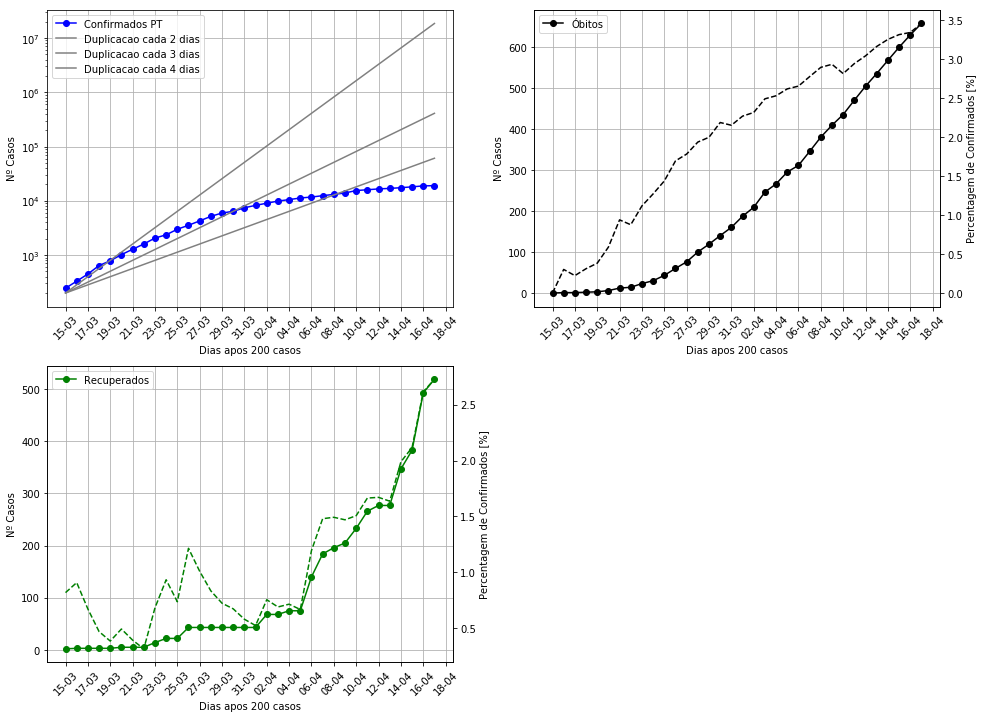

In [113]:
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['ConfirmedCases'], '-o', color='blue', label='Confirmados PT')
plt.yscale('log')

# Referencia
n_dias_dup = 2
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 2 dias', color='grey')
n_dias_dup = 3
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 3 dias', color='grey')
n_dias_dup = 4
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(pt_casos['ndia'])))
plt.plot(pt_casos['Date'], y_dup, label='Duplicacao cada 4 dias', color='grey')

plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Nº Casos')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Deaths'], '-o', color='black', label='Óbitos')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['DeathsPerc'], '--', color='black', label='Óbitos percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.subplot(2, 2, 3)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Recovered'], '-o', color='green', label='Recuperados')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['RecoveredPerc'], '--', color='green', label='Recuperados percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))


### Casos Hospitalizados e UCI

Número de casos registados em cada dia e qual é a sua percentagem dos casos confirmados

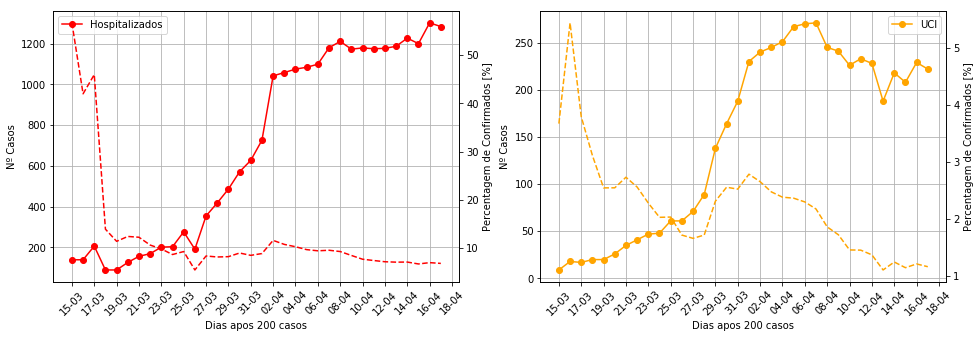

In [114]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['Hospitalized'], '-o', color='red', label='Hospitalizados')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['HospitalizedPerc'], '--', color='red', label='Hospitalizados percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['UCI'], '-o', color='orange', label='UCI')
plt.ylabel('Nº Casos')
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.xticks(rotation=45)
plt.legend()

ax = plt.gca()
ax2 = ax.twinx()
p = ax2.plot(pt_casos['Date'], pt_casos['UCIPerc'], '--', color='orange', label='UCI percentagem')
ax2.set_ylabel('Percentagem de Confirmados [%]')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

plt.show()

## Taxas de crescimento <a name="taxas_crescimento"></a>

Crescimento é dado pelo declive das amostras em escala logaritmica por unidade de tempo ($dia^{-1}$). [Ver mais](http://e-escola.tecnico.ulisboa.pt/topico.asp?id=233&ordem=2)

O crescimento foi calculado para uma janela de 4 dias, ou seja, cada ponto corresponde ao crescimento do dia e dos 3 anteriores. Desta forma eliminamos as variações rápidas entre cada dia e obtemos um recta mais suave. Podemos diminuir esta janela até 2 dias para observar o crescimento de dia para dia ou no limite até ao periodo todo para analisarmos o crescimento no seu global.

Dados:
* Casos confirmados
* Hospitalizados e internados em UCI
* Óbitos
* Recuperados


In [115]:
janela_temporal = 4 # dias (minimo 2 dias)

pt_casos['TaxaCrescimentoConfirmadasJanela'] = pt_casos['LogGrowthCases'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoHospitalizadosJanela'] = pt_casos['LogGrowthHospitalized'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoUCIJanela'] = pt_casos['LogGrowthUCI'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoMortosJanela'] = pt_casos['LogGrowthDeaths'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)
pt_casos['TaxaCrescimentoRecuperadosJanela'] = pt_casos['LogGrowthRecovered'].rolling(janela_temporal).apply(lambda x: np.polyfit(range(janela_temporal), x, 1)[0], raw=True)


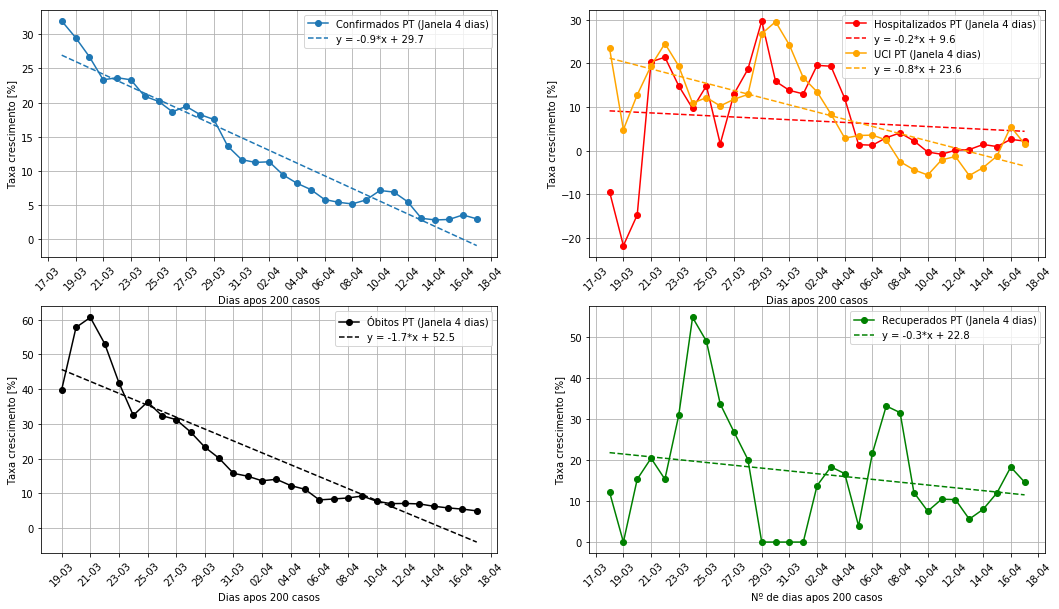

In [116]:
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoConfirmadasJanela']*100, '-o', label='Confirmados PT (Janela ' + str(janela_temporal) +' dias)')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoConfirmadasJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoConfirmadasJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoConfirmadasJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='C0', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
# Hospitalizados
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoHospitalizadosJanela']*100, '-o', label='Hospitalizados PT (Janela ' + str(janela_temporal) +' dias)', color='red')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoHospitalizadosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoHospitalizadosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoHospitalizadosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='red', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )
# UCI
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoUCIJanela']*100, '-o', label='UCI PT (Janela '+ str(janela_temporal)+' dias)', color='orange')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoUCIJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoUCIJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoUCIJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='orange', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoMortosJanela']*100, '-o', label='Óbitos PT (Janela ' + str(janela_temporal) +' dias)', color='black')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoMortosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoMortosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoMortosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='black', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TaxaCrescimentoRecuperadosJanela']*100, '-o', label='Recuperados PT (Janela ' + str(janela_temporal) +' dias)', color='green')
# fit
x = pt_casos.ndia[pt_casos['TaxaCrescimentoRecuperadosJanela'].notnull()]
params = np.polyfit(x, pt_casos['TaxaCrescimentoRecuperadosJanela'].dropna(), 1)
date = pt_casos.Date[pt_casos['TaxaCrescimentoRecuperadosJanela'].notnull()]
plt.plot(date, (params[0]*100)*x+params[1]*100, '--', color='green', label='y = %.1f*x + %.1f' % (params[0]*100,params[1]*100) )

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.xlabel('Nº de dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Taxa crescimento [%]')
plt.legend()
plt.show()

## Numero de Testes <a name="numero_testes"></a>

Número de testes obtido pelo total de casos, que inclui o número de casos confirmados, casos não confirmados e que aguardam teste.

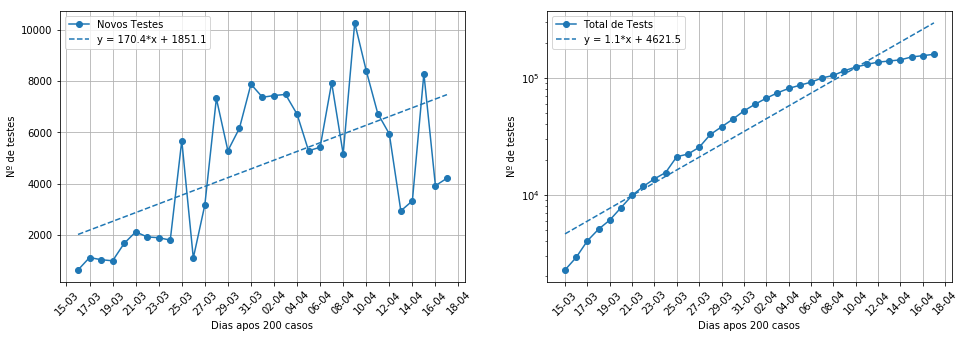

In [117]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['NewTests'], '-o', label='Novos Testes')
# fit
x = pt_casos.ndia[pt_casos['NewTests'].notnull()]
params = np.polyfit(x, pt_casos['NewTests'].dropna(), 1)
date = pt_casos.Date[pt_casos['NewTests'].notnull()]
plt.plot(date, (params[0])*x+params[1], '--', color='C0', label='y = %.1f*x + %.1f' % (params[0], params[1]))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.xlabel('Dias apos ' + str(n_casos_analise) +' casos')
plt.ylabel('Nº de testes')
plt.legend()

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(pt_casos['Date'], pt_casos['TotalTests'], '-o', label='Total de Tests')
plt.yscale('log')
# fit
x = pt_casos.ndia[pt_casos['TotalTests'].notnull()]
params = np.polyfit(x, np.log(pt_casos['TotalTests'].dropna()), 1)
date = pt_casos.Date[pt_casos['TotalTests'].notnull()]

y = np.exp(params[0]*x) * np.exp(params[1])
plt.plot(date, y, '--', color='C0', label='y = %.1f*x + %.1f' % (np.exp(params[0]), np.exp(params[1])))

plt.xlabel('Dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Nº de testes')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.show()

Taxa de Transmissibilidade ($R_0$)

## COMPARAÇÃO COM OUTROS PAISES <a name="comparacao_outros_paises"></a>

Como os dados de Potugal comparam com os da Espanha, Itália e UK tanto em valores absolutos como por milhão de habitantes.

Fontes:
 * Dados de outros países do Johns Hopkins [Aqui](https://github.com/CSSEGISandData/COVID-19)
 * Dados da população [Aqui](https://github.com/datasets/population)

### Confirmados, Óbitos e Recuperados

In [118]:
def clean_data(df_raw):
    """ cleandata: transform the John Hopkins dataset to a format easier to work with in pandas
    source: https://towardsdatascience.com/analyzing-coronavirus-covid-19-data-using-pandas-and-plotly-2e34fe2c4edc
    """
    df_cleaned=df_raw.melt(id_vars=['Province/State','Country/Region','Lat','Long'], value_name='Cases',var_name='Date')
    df_cleaned['Date']=pd.to_datetime(df_cleaned['Date'], format=r"%m/%d/%y")
    #df_cleaned=df_cleaned.set_index(['Date'])    
    return df_cleaned 

def join_dataframes(df_confirmed, df_deaths, df_recovered, country):
    conf = df_confirmed[(df_confirmed['Country/Region']==country)]
    deaths = df_deaths[(df_deaths['Country/Region']==country)]
    recov = df_recovered[(df_recovered['Country/Region']==country)]

    df = pd.DataFrame(data={'Country' : country
                           ,'Date' : conf['Date'].unique()
                           ,'ConfirmedCases' : np.array(conf.groupby(['Date']).agg({'Cases':['sum']})).flatten()
                           ,'Deaths' : np.array(deaths.groupby(['Date']).agg({'Cases':['sum']})).flatten()
                           ,'Recovered' : np.array(recov.groupby(['Date']).agg({'Cases':['sum']})).flatten()})
    return df


def calc_cases_per_million_inhabitants(df, population):
    df['ConfirmedCasesPerMillion'] = (df['ConfirmedCases'] * 1e6) / population
    df['DeathsPerMillion'] = (df['Deaths'] * 1e6) / population
    df['RecoveredPerMillion'] = (df['Recovered'] * 1e6) / population
    return df

In [119]:
# GitHUb source: https://github.com/CSSEGISandData/COVID-19
confirmed_cases_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# GitHub source: https://github.com/datasets/population/tree/master/data
population = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')

confirmed_cases = clean_data(confirmed_cases_raw)
deaths_cases = clean_data(deaths_raw)
recoveries_cases = clean_data(recoveries_raw)


In [120]:
populacao_pt = population[(population['Country Name']=='Portugal')].iloc[-1].Value
pt_casos = calc_cases_per_million_inhabitants(pt_casos, populacao_pt)

# Espanha
dados_es = join_dataframes(confirmed_cases, deaths_cases, recoveries_cases, 'Spain')
es_casos = dados_es.loc[dados_es['ConfirmedCases'] >= n_casos_analise, :].copy()
es_casos['ndia'] = np.arange(len(es_casos['ConfirmedCases']))
populacao_es = population[(population['Country Name']=='Spain')].iloc[-1].Value

es_casos = calc_cases_per_million_inhabitants(es_casos, populacao_es)

# Italia
dados_it = join_dataframes(confirmed_cases, deaths_cases, recoveries_cases, 'Italy')
it_casos = dados_it.loc[dados_it['ConfirmedCases'] >= n_casos_analise, :].copy()
it_casos['ndia'] = np.arange(len(it_casos['ConfirmedCases']))
populacao_it = population[(population['Country Name']=='Italy')].iloc[-1].Value

it_casos = calc_cases_per_million_inhabitants(it_casos, populacao_it)

# Reino Unido
dados_uk = join_dataframes(confirmed_cases, deaths_cases, recoveries_cases, 'United Kingdom')
uk_casos = dados_uk.loc[dados_uk['ConfirmedCases'] >= n_casos_analise, :].copy()
uk_casos['ndia'] = np.arange(len(uk_casos['ConfirmedCases']))
populacao_uk = population[(population['Country Name']=='United Kingdom')].iloc[-1].Value

uk_casos = calc_cases_per_million_inhabitants(uk_casos, populacao_uk)

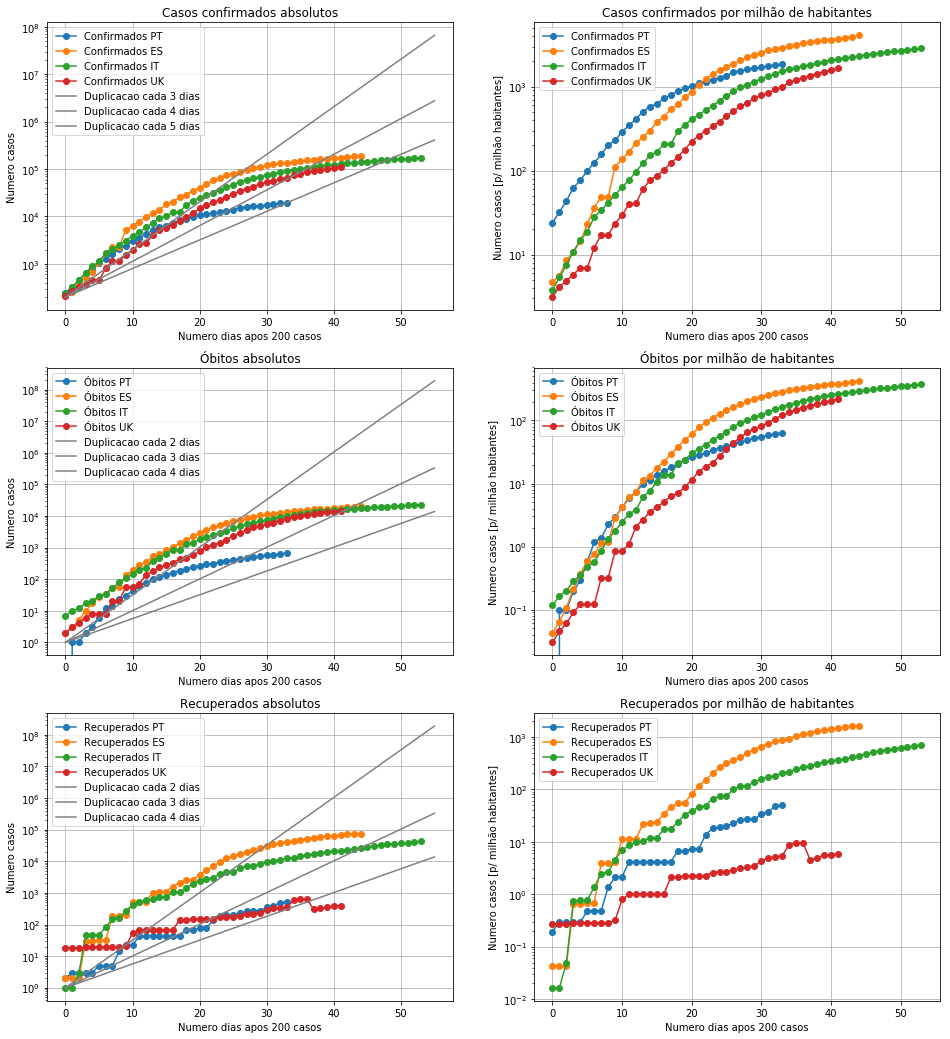

In [121]:
plt.figure(figsize=(16,18))
plt.subplot(3, 2, 1)
plt.grid()
plt.title('Casos confirmados absolutos')
plt.plot(pt_casos['ndia'], pt_casos['ConfirmedCases'], '-o', label='Confirmados PT')
plt.plot(es_casos['ndia'], es_casos['ConfirmedCases'], '-o', label='Confirmados ES')
plt.plot(it_casos['ndia'], it_casos['ConfirmedCases'], '-o', label='Confirmados IT')
plt.plot(uk_casos['ndia'], uk_casos['ConfirmedCases'], '-o', label='Confirmados UK')
plt.yscale('log')

# Referencia
xmin, xmax = plt.gca().get_xlim()
x = np.arange(xmax)

#n_dias_dup = 2
#y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
#plt.plot(x, y_dup, label='Duplicacao cada 2 dias', color='grey')

n_dias_dup = 3
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 4
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 5
y_dup = n_casos_analise*np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')


plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos')
plt.legend()

plt.subplot(3, 2, 2)
plt.grid()
plt.title('Casos confirmados por milhão de habitantes')
plt.plot(pt_casos['ndia'], pt_casos['ConfirmedCasesPerMillion'], '-o', label='Confirmados PT')
plt.plot(es_casos['ndia'], es_casos['ConfirmedCasesPerMillion'], '-o', label='Confirmados ES')
plt.plot(it_casos['ndia'], it_casos['ConfirmedCasesPerMillion'], '-o', label='Confirmados IT')
plt.plot(uk_casos['ndia'], uk_casos['ConfirmedCasesPerMillion'], '-o', label='Confirmados UK')
plt.yscale('log')
plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos [p/ milhão habitantes]')
plt.legend()

plt.subplot(3, 2, 3)
plt.title('Óbitos absolutos')
plt.grid()
plt.plot(pt_casos['ndia'], pt_casos['Deaths'], '-o', label='Óbitos PT')
plt.plot(es_casos['ndia'], es_casos['Deaths'], '-o', label='Óbitos ES')
plt.plot(it_casos['ndia'], it_casos['Deaths'], '-o', label='Óbitos IT')
plt.plot(uk_casos['ndia'], uk_casos['Deaths'], '-o', label='Óbitos UK')
plt.yscale('log')

# Referencia
xmin, xmax = plt.gca().get_xlim()
x = np.arange(xmax)
n_dias_dup = 2
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 3
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 4
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos')
plt.legend()

plt.subplot(3, 2, 4)
plt.grid()
plt.title('Óbitos por milhão de habitantes')
plt.plot(pt_casos['ndia'], pt_casos['DeathsPerMillion'], '-o', label='Óbitos PT')
plt.plot(es_casos['ndia'], es_casos['DeathsPerMillion'], '-o', label='Óbitos ES')
plt.plot(it_casos['ndia'], it_casos['DeathsPerMillion'], '-o', label='Óbitos IT')
plt.plot(uk_casos['ndia'], uk_casos['DeathsPerMillion'], '-o', label='Óbitos UK')
plt.yscale('log')
plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos [p/ milhão habitantes]')
plt.legend()

plt.subplot(3, 2, 5)
plt.grid()
plt.title('Recuperados absolutos')
plt.plot(pt_casos['ndia'], pt_casos['Recovered'], '-o', label='Recuperados PT')
plt.plot(es_casos['ndia'], es_casos['Recovered'], '-o', label='Recuperados ES')
plt.plot(it_casos['ndia'], it_casos['Recovered'], '-o', label='Recuperados IT')
plt.plot(uk_casos['ndia'], uk_casos['Recovered'], '-o', label='Recuperados UK')
plt.yscale('log')

# Referencia
xmin, xmax = plt.gca().get_xlim()
x = np.arange(xmax)
n_dias_dup = 2
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 3
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

n_dias_dup = 4
y_dup = np.exp((np.log(2)/n_dias_dup)*np.arange(len(x)))
plt.plot(x, y_dup, label='Duplicacao cada ' + str(n_dias_dup) +' dias', color='grey')

plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos')
plt.legend()

plt.subplot(3, 2, 6)
plt.grid()
plt.title('Recuperados por milhão de habitantes')
plt.plot(pt_casos['ndia'], pt_casos['RecoveredPerMillion'], '-o', label='Recuperados PT')
plt.plot(es_casos['ndia'], es_casos['RecoveredPerMillion'], '-o', label='Recuperados ES')
plt.plot(it_casos['ndia'], it_casos['RecoveredPerMillion'], '-o', label='Recuperados IT')
plt.plot(uk_casos['ndia'], uk_casos['RecoveredPerMillion'], '-o', label='Recuperados UK')
plt.yscale('log')

plt.xlabel('Numero dias apos ' + str(n_casos_analise) + ' casos')
plt.ylabel('Numero casos [p/ milhão habitantes]')
plt.legend()

plt.show()

### Taxas de crescimentos